In [26]:
%reset -f

import sys

import numpy as np
import pandas as pd
import time
sys.path.insert(
    1, '/Users/haas/Documents/Masters/ml_lattice_qcd'
)

import random

import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from activation_functions import *
from FFNN import FFNN

# import accuracy score
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    mean_squared_error,
)
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, BatchNormalization, SeparableConv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from utils import *

cmt = 1 / 2.54
sns.set_palette('pastel')

### Here I display 5 implementations of possible paths to make the training process for the cnn faster (or give better score in less epochs).

1. Adding a lerning rate scheduler on top of ADAM
2. Adding batch normalization 
3. Depthwise separable convolutions
4. Transfer learning
5. Proper gridsearch on parameters

## Here is what we had before

2023-03-03 15:35:43.016219: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


8/8 [==============================] - 0s 4ms/step
RMSE1:  0.16094512448777698
rmse over average of ytest with LeNet-5 =  0.0729354215468799
CPU times: user 21.3 s, sys: 2.17 s, total: 23.5 s
Wall time: 6.66 s


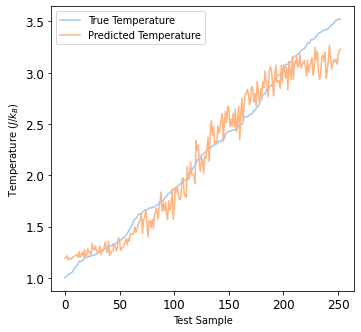

In [6]:
%%time

# lenet inspired model
# now we replicate LeNet-5
Xtrain, Xtest, ytrain, ytest = Ising.load_data()
# first reshape Xtrain and Xtest to 4D arrays
Xtrain = Xtrain.reshape(Xtrain.shape[0], 50, 50, 1)
Xtest = Xtest.reshape(Xtest.shape[0], 50, 50, 1)
# create model
model1 = Sequential()
# add model layers
eta = 1e-4
l2 = 0.01
l2_reg = regularizers.l2(l2)
epochs = 1000
model1.add(
    Conv2D(
        6,
        kernel_size=5,
        activation='leaky_relu',
        input_shape=(50, 50, 1),
        kernel_regularizer=l2_reg,
        padding='same',
    )
)
# model.add(AveragePooling2D(pool_size=(4, 4)))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(
    Conv2D(
        16,
        kernel_size=5,
        activation='leaky_relu',
        kernel_regularizer=l2_reg,
        padding='same',
    )
)
model1.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(AveragePooling2D(pool_size=(4, 4)))
model1.add(Flatten())
model1.add(Dense(120, activation='relu', kernel_regularizer=l2_reg))
model1.add(Dense(84, activation='relu', kernel_regularizer=l2_reg))
model1.add(Dense(1, activation='linear'))
# compile model using accuracy to measure model performance
sgd = SGD(learning_rate=eta, decay=5e-6, momentum=0.9, nesterov=True)
adam = Adam(learning_rate=eta, beta_1=0.9, beta_2=0.999, amsgrad=False)

model1.compile(optimizer=adam, loss='mse', metrics='mse')
# train the model
history1 = model1.fit(
    Xtrain, ytrain, validation_data=(Xtest, ytest), epochs=epochs, verbose=0
)   #### change this
#
# evaluate the model
pred1 = model1.predict(Xtest)
order = np.argsort(ytest.ravel())
ytest = ytest[order]
pred1 = pred1[order]

# plot predictions
plt.rcParams.update({'font.size': 12})

fig = plt.figure(figsize=(13 * cmt, 12 * cmt))
plt.plot(ytest, label='True Temperature')
plt.plot(pred1, label='Predicted Temperature')
plt.legend() 
plt.xlabel('Test Sample')
plt.ylabel('Temperature $(J/k_B)$')
# change ticks font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


info = (
    f'_l2reg{str(l2).replace(".", "")}'
    + '_eta'
    + str(eta).replace('.', '')
    + f'_epoch{str(epochs)}'
)
plt.tight_layout()
plt.savefig('../figs/TF_CNN' + info + '.pdf')


print('RMSE1: ', mean_squared_error(ytest, pred1, squared=False))
rmse1 = np.sqrt(mean_squared_error(pred1, ytest.ravel())) / np.mean(ytest)
print('rmse over average of ytest = ', rmse1)


In [33]:
Xtrain, Xtest, ytrain, ytest = Ising.load_data()
# first reshape Xtrain and Xtest to 4D arrays
Xtrain = Xtrain.reshape(Xtrain.shape[0], 50, 50, 1)
Xtest = Xtest.reshape(Xtest.shape[0], 50, 50, 1)
np.shape(Xtrain[0])

(50, 50, 1)

In [34]:
Xtrain[0]

array([[[ 1.],
        [-1.],
        [-1.],
        ...,
        [ 1.],
        [-1.],
        [ 1.]],

       [[-1.],
        [-1.],
        [-1.],
        ...,
        [ 1.],
        [ 1.],
        [-1.]],

       [[-1.],
        [-1.],
        [-1.],
        ...,
        [ 1.],
        [ 1.],
        [-1.]],

       ...,

       [[ 1.],
        [-1.],
        [-1.],
        ...,
        [ 1.],
        [ 1.],
        [-1.]],

       [[ 1.],
        [ 1.],
        [-1.],
        ...,
        [ 1.],
        [ 1.],
        [-1.]],

       [[ 1.],
        [ 1.],
        [-1.],
        ...,
        [ 1.],
        [ 1.],
        [ 1.]]])

# Now I will try to speed up the training process and measure it in a more systematic way

In [9]:
Xtrain, Xtest, ytrain, ytest = Ising.load_data()
Xtrain = Xtrain.reshape(Xtrain.shape[0], 50, 50, 1)
Xtest = Xtest.reshape(Xtest.shape[0], 50, 50, 1)

In [10]:
def train_time_exploration(eta, l2, epochs, Xtrain, Xtest, ytrain, ytest, scheduler = False, bach_norm = False):
    model1 = Sequential()
    # add model layers

    l2_reg = regularizers.l2(l2)
    model1.add(
        Conv2D(
            6,
            kernel_size=5,
            activation='leaky_relu',
            input_shape=(50, 50, 1),
            kernel_regularizer=l2_reg,
            padding='same',
        )
    )

    model1.add(MaxPooling2D(pool_size=(2, 2)))
    if bach_norm:
        model1.add(BatchNormalization())

    model1.add(
        Conv2D(
            16,
            kernel_size=5,
            activation='leaky_relu',
            kernel_regularizer=l2_reg,
            padding='same',
        )
    )
    model1.add(MaxPooling2D(pool_size=(2, 2)))
    if bach_norm:
        model1.add(BatchNormalization())

    model1.add(Flatten())
    model1.add(Dense(120, activation='relu', kernel_regularizer=l2_reg))
    model1.add(Dense(84, activation='relu', kernel_regularizer=l2_reg))
    model1.add(Dense(1, activation='linear'))

    # sgd = SGD(learning_rate=eta, decay=5e-6, momentum=0.9, nesterov=True)
    if scheduler != False:
        eta = ExponentialDecay(
            initial_learning_rate=eta,
            decay_steps=10000,
            decay_rate=0.9)

    adam = Adam(learning_rate=eta, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model1.compile(optimizer=adam, loss='mse', metrics='mse')

    # train the model
    history1 = model1.fit(
        Xtrain, ytrain, validation_data=(Xtest, ytest), epochs=epochs, verbose=0
    )   #### change this

    # evaluate the model
    pred1 = model1.predict(Xtest)
    order = np.argsort(ytest.ravel())
    ytest = ytest[order]
    pred1 = pred1[order]

    # plot predictions
    #plt.rcParams.update({'font.size': 12})
    #fig = plt.figure(figsize=(13 * cmt, 12 * cmt))
    #plt.plot(ytest, label='True Temperature')
    #plt.plot(pred1, label='Predicted Temperature')
    #plt.legend()
    #plt.xlabel('Test Sample')
    #plt.ylabel('Temperature $(J/k_B)$')
    ## change ticks font size
    #plt.xticks(fontsize=12)
    #plt.yticks(fontsize=12)
#
#
    #info = (
    #    f'_l2reg{str(l2).replace(".", "")}'
    #    + '_eta'
    #    + str(eta).replace('.', '')
    #    + f'_epoch{str(epochs)}'
    #)
    #plt.tight_layout()
    #plt.savefig('../figs/TF_CNN' + info + '.pdf')


    #print('RMSE1: ', mean_squared_error(ytest, pred1, squared=False))
    rmse1 = np.sqrt(mean_squared_error(pred1, ytest.ravel())) / np.mean(ytest)
    #print('rmse over average of ytest', rmse1)
    return rmse1, history1


In [11]:
eta = 1e-4
l2 = 0.01
rmse_no_scheduler_list = []
rmse_scheduler_list = []
times_no_scheduler = []
times_scheduler = []
list_of_epochs = range(100, 200, 10)
    # time the training
for epochs in list_of_epochs:
    start_no_scheduler = time.time()
    rmse_no_scheduler, history_no_scheduler =  train_time_exploration(eta, l2, epochs, Xtrain, Xtest, ytrain, ytest, scheduler = False)
    end_no_scheduler = time.time()
    start_scheduler = time.time()
    rmse_scheduler, history_scheduler = train_time_exploration(eta, l2, epochs, Xtrain, Xtest, ytrain, ytest, scheduler = True)
    end_scheduler = time.time()
    times_no_scheduler.append(end_no_scheduler - start_no_scheduler)
    times_scheduler.append(end_scheduler - start_scheduler)
    rmse_no_scheduler_list.append(rmse_no_scheduler)
    rmse_scheduler_list.append(rmse_scheduler)


8/8 [==============================] - 0s 4ms/step


Text(0, 0.5, 'Time (s)')

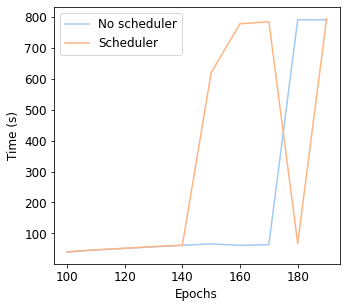

In [12]:
# plot times per epoch
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(13 * cmt, 12 * cmt))
plt.plot(list_of_epochs, times_no_scheduler, label='No scheduler')
plt.plot(list_of_epochs, times_scheduler, label='Scheduler')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Time (s)')



Text(0, 0.5, 'RMSE')

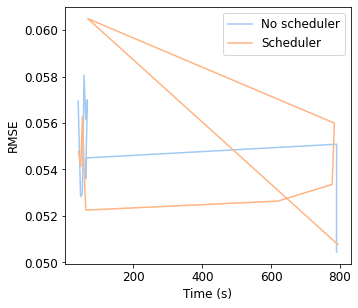

In [13]:
# plot rmse per time
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(13 * cmt, 12 * cmt))
plt.plot(times_no_scheduler, rmse_no_scheduler_list, label='No scheduler')
plt.plot(times_scheduler, rmse_scheduler_list, label='Scheduler')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('RMSE')


Text(0, 0.5, 'Loss')

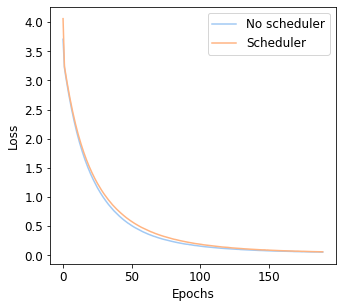

In [14]:
## plot history
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(13 * cmt, 12 * cmt))
plt.plot(history_no_scheduler.history['loss'], label='No scheduler')
plt.plot(history_scheduler.history['loss'], label='Scheduler')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')


### Second Idea: batch normalization

In [15]:
eta = 1e-4
l2 = 0.01
rmse_no_norm_list = []
rmse_norm_list = []
times_no_norm = []
times_norm = []
list_of_epochs = range(100, 200, 10)
    # time the training
for epochs in list_of_epochs:
    start_no_norm = time.time()
    rmse_no_norm, history_no_norm =  train_time_exploration(eta, l2, epochs, Xtrain, Xtest, ytrain, ytest, scheduler = False, bach_norm = False)
    end_no_norm = time.time()
    start_norm = time.time()
    rmse_norm, history_norm = train_time_exploration(eta, l2, epochs, Xtrain, Xtest, ytrain, ytest, scheduler = False, bach_norm = True)
    end_norm = time.time()
    times_no_norm.append(end_no_norm - start_no_norm)
    times_norm.append(end_norm - start_norm)
    rmse_no_norm_list.append(rmse_no_norm)
    rmse_norm_list.append(rmse_norm)


8/8 [==============================] - 0s 13ms/step


Text(0, 0.5, 'RMSE')

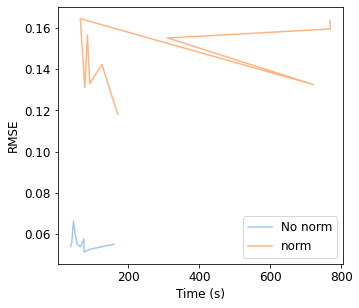

In [16]:
# plot rmse per time
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(13 * cmt, 12 * cmt))
plt.plot(times_no_norm, rmse_no_norm_list, label='No norm')
plt.plot(times_norm, rmse_norm_list, label='norm')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('RMSE')


Text(0, 0.5, 'Time (s)')

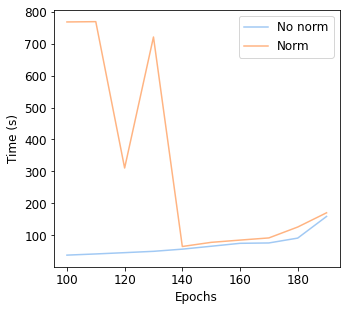

In [17]:
# plot times per epoch
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(13 * cmt, 12 * cmt))
plt.plot(list_of_epochs, times_no_norm, label='No norm')
plt.plot(list_of_epochs, times_norm, label='Norm')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Time (s)')


Text(0, 0.5, 'Loss')

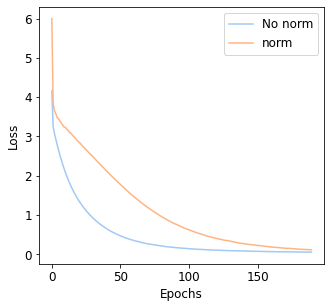

In [18]:
## plot history
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(13 * cmt, 12 * cmt))
plt.plot(history_no_norm.history['loss'], label='No norm')
plt.plot(history_norm.history['loss'], label='norm')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')


### Another idea "depthwise separable convolutions"

8/8 [==============================] - 0s 17ms/step
RMSE1:  0.16252043063083332
rmse over average of ytest =  0.07364930224363832
CPU times: user 37.6 s, sys: 2.19 s, total: 39.8 s
Wall time: 27.7 s


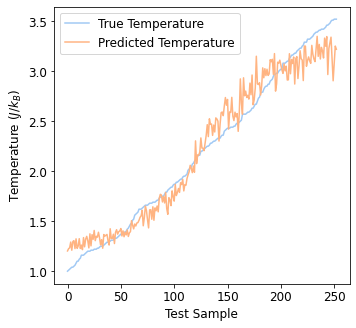

In [30]:
%%time

# lenet inspired model
# now we replicate LeNet-5
Xtrain, Xtest, ytrain, ytest = Ising.load_data()
# first reshape Xtrain and Xtest to 4D arrays
Xtrain = Xtrain.reshape(Xtrain.shape[0], 50, 50, 1)
Xtest = Xtest.reshape(Xtest.shape[0], 50, 50, 1)
# create model
model1 = Sequential()
# add model layers
eta = 1e-4
l2 = 0.01
l2_reg = regularizers.l2(l2)
epochs = 20
model1.add(
    SeparableConv2D(6,
        kernel_size=5,
        activation='leaky_relu',
        input_shape=(50, 50, 1),
        kernel_regularizer=l2_reg,
        padding='same',
    )
)
# model.add(AveragePooling2D(pool_size=(4, 4)))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(
    SeparableConv2D(
        16,
        kernel_size=5,
        activation='leaky_relu',
        kernel_regularizer=l2_reg,
        padding='same',
    )
)
model1.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(AveragePooling2D(pool_size=(4, 4)))
model1.add(Flatten())
model1.add(Dense(120, activation='relu', kernel_regularizer=l2_reg))
model1.add(Dense(84, activation='relu', kernel_regularizer=l2_reg))
model1.add(Dense(1, activation='linear'))
# compile model using accuracy to measure model performance
sgd = SGD(learning_rate=eta, decay=5e-6, momentum=0.9, nesterov=True)
adam = Adam(learning_rate=eta, beta_1=0.9, beta_2=0.999, amsgrad=False)

model1.compile(optimizer=adam, loss='mse', metrics='mse')
# train the model
history1 = model1.fit(
    Xtrain, ytrain, validation_data=(Xtest, ytest), epochs=epochs, verbose=0
)   #### change this
#
# evaluate the model
pred1 = model1.predict(Xtest)
order = np.argsort(ytest.ravel())
ytest = ytest[order]
pred1 = pred1[order]

# plot predictions
plt.rcParams.update({'font.size': 12})

fig = plt.figure(figsize=(13 * cmt, 12 * cmt))
plt.plot(ytest, label='True Temperature')
plt.plot(pred1, label='Predicted Temperature')
plt.legend() 
plt.xlabel('Test Sample')
plt.ylabel('Temperature $(J/k_B)$')
# change ticks font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


info = (
    f'_l2reg{str(l2).replace(".", "")}'
    + '_eta'
    + str(eta).replace('.', '')
    + f'_epoch{str(epochs)}'
)
plt.tight_layout()
plt.savefig('../figs/TF_CNN' + info + '.pdf')


print('RMSE1: ', mean_squared_error(ytest, pred1, squared=False))
rmse1 = np.sqrt(mean_squared_error(pred1, ytest.ravel())) / np.mean(ytest)
print('rmse over average of ytest = ', rmse1)

### Another idea: transfer learning

In [19]:
## now lets use transfer learning from the well known model VGG16 trained on imagenet
# import vgg from keras
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import backend as K



In [20]:
# create the base pre-trained model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

In [21]:

# now we add our own layers to make regression on the temperature
l2_reg = regularizers.l2(l2)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(120, activation='relu', kernel_regularizer=l2_reg)(x)
x = Dense(84, activation='relu', kernel_regularizer=l2_reg)(x)
predictions = Dense(1, activation='linear')(x)



In [22]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [23]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam', loss='mse', metrics='mse')

In [24]:
# train the model on the new data for a few epochs
history = model.fit(Xtrain, ytrain, validation_data=(Xtest, ytest), epochs=10, verbose=0)


ValueError: in user code:

    File "/Users/haas/.pyenv/versions/3.10.2/lib/python3.10/site-packages/keras/engine/training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "/Users/haas/.pyenv/versions/3.10.2/lib/python3.10/site-packages/keras/engine/training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/haas/.pyenv/versions/3.10.2/lib/python3.10/site-packages/keras/engine/training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "/Users/haas/.pyenv/versions/3.10.2/lib/python3.10/site-packages/keras/engine/training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "/Users/haas/.pyenv/versions/3.10.2/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/haas/.pyenv/versions/3.10.2/lib/python3.10/site-packages/keras/engine/input_spec.py", line 277, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "model" "                 f"(type Functional).
    
    Input 0 of layer "block1_conv1" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (None, 50, 50, 1)
    
    Call arguments received by layer "model" "                 f"(type Functional):
      • inputs=tf.Tensor(shape=(None, 50, 50, 1), dtype=float32)
      • training=True
      • mask=None


In [ ]:
# evaluate the model
pred = model.predict(Xtest)
order = np.argsort(ytest.ravel())
ytest = ytest[order]
pred = pred[order]

# plot predictions
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(13 * cmt, 12 * cmt))
plt.plot(ytest, label='True Temperature')
plt.plot(pred, label='Predicted Temperature')
plt.legend()
plt.xlabel('Test Sample')
plt.ylabel('Temperature $(J/k_B)$')
# change ticks font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

info = (
    f'VGG_l2reg{str(l2).replace(".", "")}'
    + '_eta'
    + str(eta).replace('.', '')
    + f'_epoch{str(epochs)}'
)
plt.tight_layout()
plt.savefig('../figs/TF_CNN' + info + '.pdf')

### Last idea: making a proper grid search with at least 3 params 